In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.metrics import accuracy_score, f1_score, precision_score , recall_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import roc_curve, plot_roc_curve, roc_auc_score
from sklearn.preprocessing import Binarizer


from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score



import warnings
warnings.filterwarnings(action='ignore')

In [2]:
def my_eval(y_val, pred, proba, th):  #avg='binary'
        accuracy = accuracy_score(y_val, pred)
        precision = precision_score(y_val, pred)
        recall = recall_score(y_val, pred)
        f1 = f1_score(y_val, pred)
        matrix = confusion_matrix(y_val, pred)
        print(f'정확도{accuracy:.4f} 정밀도:{precision:.4f} 재현률:{recall:.4f} f1:{f1:.4f}')
        print("오차행렬\n", matrix)
        # cls_report = classification_report(y_val, pred)

        # --------------- 양성 평가를 위한 차트 : precision_recall_curv() -------------------    
        # plot_precision_recall_curve(model, 문제지2, 정답지2)
        precisions, recalls, ths = precision_recall_curve(y_val, proba[:, 1])
        plt.title("precision recall curv %0.2f %0.4f"%(th,f1))
        # plt.title(f"precision recall curv %0.4f" % f1)
        plt.xlabel("threadhold")
        plt.ylabel("value")
        plt.plot(ths, precisions[:ths.shape[0]], "b", label="precision")
        plt.plot(ths, recalls[:ths.shape[0]], "r", linestyle='--', label="recall")
        plt.grid()
        plt.legend()
        plt.show()
        
        
        # --------------- 양성 평가를 위한 차트 : roc_auc_score(), roc_curve() -------------------
        auc_score = roc_auc_score(y_val, proba[:, 1])

        fprs, tprs, ths = roc_curve(y_val, proba[:, 1])
        plt.title("roc curv %0.4f" % auc_score)
        # plt.title(f"precision recall curv %0.4f" % f1)
        plt.xlabel("FPR(1-specificity)")
        plt.ylabel("TPR")
        plt.grid()
        plt.plot(fprs, tprs, "b")
        plt.plot([0, 1], [0, 1], '--', color='black')
        plt.show()


def split_fit_score(X, y, model=None, test_size=0.2, th_list=None):

        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=test_size,random_state=1414,stratify=y) #shuffle = False

        model.fit(X_train, y_train)
        pred = model.predict(X_test)                                        #[0  1]              th:0.5
        proba = model.predict_proba(X_test)                                 #[[.7 >.3] [.4  <.6]]  --> [0  1]
        
        # ------------------ proba : 양성 점수 측정을 위한 예측 확률값 ---------------
        # proba 리턴값 : ndarray of shape (n_samples, n_classes)  150*3
        # [
        #     [0.4 0.6]  --> 1
        #     [0.7 0.3]  --> 0
        #     [0.42 0.58] -> 1
        # ]
        
        if th_list == None:
            #------------------방법1 ) 임계치 0.5(기본값)으로 점수 출력 ---------------
            binz = Binarizer(threshold=0.5)                              # th:0.5
            pred_binz = binz.fit_transform(proba[:, 1].reshape(-1,1))    # [[.7 >.3] [.4  <.6]]  --> [0  1]
            my_eval(y_test, pred_binz, proba, 0.5)                        # 점수def호출
 
        else:
            # ----------------방법2) 임계치 조정해가면서 최적의 점수 찾기---------------
            # (24 양성인데 틀리게예측) --> 임계치 낮춘다 == 양성학습데이터늘린다  == 양성점수를 올린다 
            th_list = [0, 0.35 , 0.38, 0.42, 0.45, 0.5, 1]
            for th in th_list:
                    binz = Binarizer(threshold=th)                              # [[.7 .3] [.4  .6]]   th:0.2
                    pred_binz = binz.fit_transform(proba[:, 1].reshape(-1,1))   # [  th<.3] [  th<.6]]  --> [1 1]
                    print(th)
                    my_eval(y_test, pred_binz, proba, th)   

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sub = pd.read_csv("sample_submission.csv")

In [4]:
train = train.drop(['index'], axis=1)
test = test.drop(['index'], axis=1)

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5456 entries, 0 to 5455
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         5456 non-null   object 
 1   car            5456 non-null   object 
 2   reality        5456 non-null   object 
 3   child_num      5456 non-null   int64  
 4   income_total   5456 non-null   float64
 5   income_type    5456 non-null   object 
 6   edu_type       5456 non-null   object 
 7   family_type    5456 non-null   object 
 8   house_type     5456 non-null   object 
 9   DAYS_BIRTH     5456 non-null   int64  
 10  DAYS_EMPLOYED  5456 non-null   int64  
 11  FLAG_MOBIL     5456 non-null   int64  
 12  work_phone     5456 non-null   int64  
 13  phone          5456 non-null   int64  
 14  email          5456 non-null   int64  
 15  occyp_type     3775 non-null   object 
 16  family_size    5456 non-null   int64  
 17  begin_month    5456 non-null   int64  
dtypes: float

In [6]:
test.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,F,Y,N,2,270000.0,Working,Secondary / secondary special,Married,With parents,-13258,-2300,1,0,0,0,Managers,4,-42
1,F,Y,Y,0,157500.0,Working,Higher education,Married,House / apartment,-21884,-1496,1,0,1,0,High skill tech staff,2,-52
2,M,N,N,0,360000.0,Commercial associate,Higher education,Single / not married,House / apartment,-9514,-461,1,1,1,1,Waiters/barmen staff,1,-10
3,F,Y,Y,0,225000.0,State servant,Secondary / secondary special,Single / not married,House / apartment,-16765,-5777,1,0,0,0,Laborers,1,-50
4,M,Y,N,0,225000.0,Working,Higher education,Married,House / apartment,-14729,-3251,1,0,0,0,Laborers,2,-7


In [7]:
test.isna().sum()

gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       1681
family_size         0
begin_month         0
dtype: int64

In [8]:
test.describe()

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month
count,5456.000000,5.456000e+03,5456.000000,5456.000000,5456.0,5456.000000,5456.000000,5456.000000,5456.000000,5456.000000
mean,0.433651,1.892003e+05,-15975.821481,58194.425953,1.0,0.221957,0.297104,0.097324,2.196481,-26.135264
std,0.751653,1.068627e+05,4161.341109,136680.612299,0.0,0.415601,0.457025,0.296426,0.922016,16.615135
min,0.000000,3.015000e+04,-25152.000000,-15072.000000,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000
25%,0.000000,1.215000e+05,-19420.500000,-3111.000000,1.0,0.000000,0.000000,0.000000,2.000000,-39.000000
50%,0.000000,1.615500e+05,-15595.000000,-1544.000000,1.0,0.000000,0.000000,0.000000,2.000000,-24.000000
75%,1.000000,2.250000e+05,-12476.500000,-412.000000,1.0,0.000000,1.000000,0.000000,3.000000,-12.000000
max,14.000000,1.350000e+06,-7723.000000,365243.000000,1.0,1.000000,1.000000,1.000000,15.000000,0.000000


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21001 entries, 0 to 21000
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         21001 non-null  object 
 1   car            21001 non-null  object 
 2   reality        21001 non-null  object 
 3   child_num      21001 non-null  int64  
 4   income_total   21001 non-null  float64
 5   income_type    21001 non-null  object 
 6   edu_type       21001 non-null  object 
 7   family_type    21001 non-null  object 
 8   house_type     21001 non-null  object 
 9   DAYS_BIRTH     21001 non-null  int64  
 10  DAYS_EMPLOYED  21001 non-null  int64  
 11  FLAG_MOBIL     21001 non-null  int64  
 12  work_phone     21001 non-null  int64  
 13  phone          21001 non-null  int64  
 14  email          21001 non-null  int64  
 15  occyp_type     14511 non-null  object 
 16  family_size    21001 non-null  int64  
 17  begin_month    21001 non-null  int64  
 18  credit

In [10]:
train.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2,-6,1
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3,-5,1
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2,-22,2
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2,-37,0
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2,-26,2


In [11]:
train.isna().sum()

gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       6490
family_size         0
begin_month         0
credit              0
dtype: int64

In [12]:
train.describe()

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit
count,21001.000000,2.100100e+04,21001.000000,21001.000000,21001.0,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000
mean,0.427361,1.868145e+05,-15953.437932,59295.897814,1.0,0.225465,0.293510,0.089710,2.196943,-26.120185,1.521261
std,0.746211,1.005398e+05,4212.068495,137683.499136,0.0,0.417898,0.455381,0.285773,0.915357,16.545474,0.702131
min,0.000000,2.700000e+04,-25140.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000,0.000000
25%,0.000000,1.215000e+05,-19431.000000,-3160.000000,1.0,0.000000,0.000000,0.000000,2.000000,-39.000000,1.000000
50%,0.000000,1.575000e+05,-15527.000000,-1539.000000,1.0,0.000000,0.000000,0.000000,2.000000,-24.000000,2.000000
75%,1.000000,2.250000e+05,-12440.000000,-401.000000,1.0,0.000000,1.000000,0.000000,3.000000,-12.000000,2.000000
max,19.000000,1.575000e+06,-7705.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,0.000000,2.000000


In [13]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5456 entries, 0 to 5455
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   5456 non-null   int64  
 1   credit  0 non-null      float64
dtypes: float64(1), int64(1)
memory usage: 85.4 KB


불균형 분류 : 0.1217, 0.2353
2    13503
1     4942
0     2556
Name: credit, dtype: int64


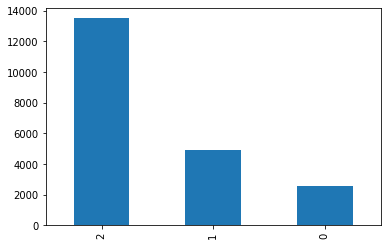

In [14]:
print( '불균형 분류 : {:.4f}, {:.4f}'.format(train[train['credit']==0].shape[0]/train.shape[0], train[train['credit']==1].shape[0] / train.shape[0] ) )
print(train['credit'].value_counts())

train['credit'].value_counts().plot(kind='bar')
plt.show()

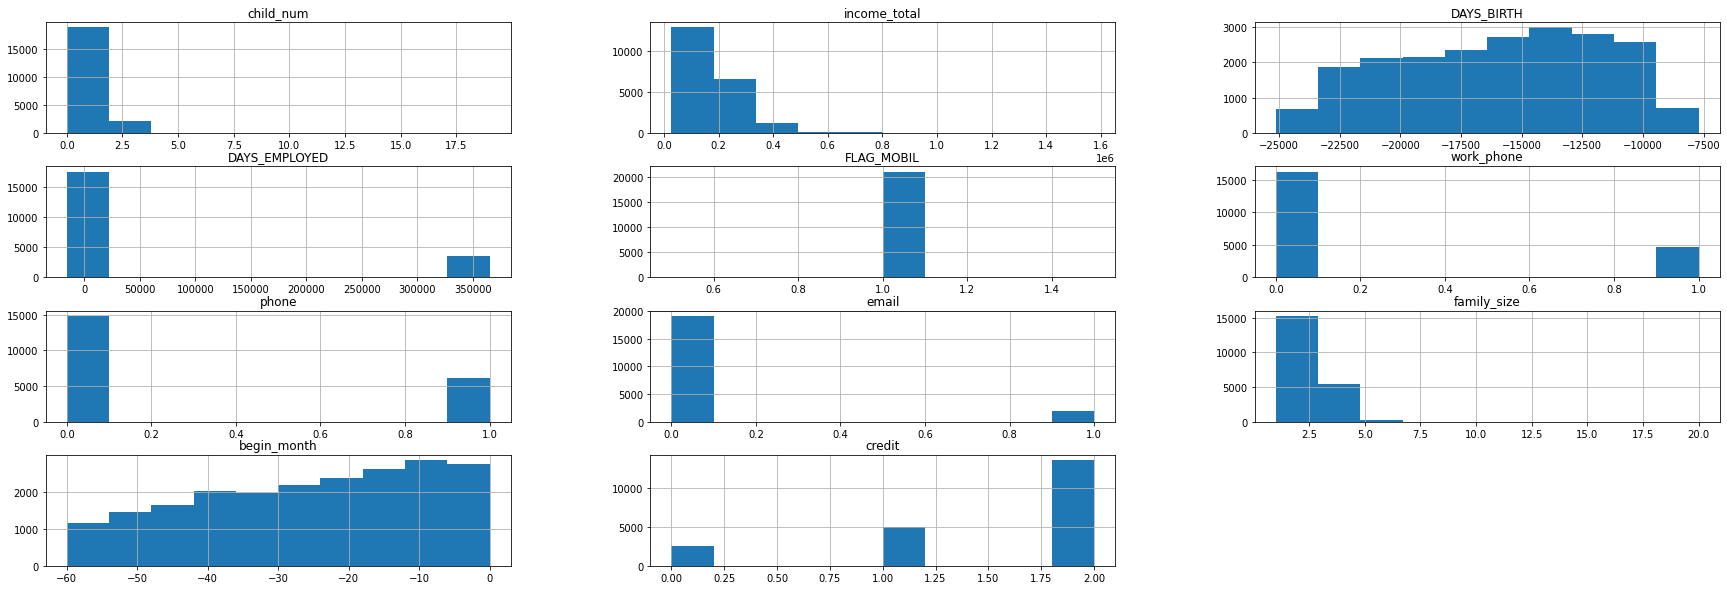

In [15]:
train.hist(figsize=(30,10))
plt.show()

In [16]:
정답지 = train["credit"]
정답지.head()

0    1
1    1
2    2
3    0
4    2
Name: credit, dtype: int64

In [17]:
정답지 = train["credit"]
정답지.head()
문제지 = train.drop("credit", axis=1)
문제지.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2,-6
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3,-5
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2,-22
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2,-37
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2,-26


In [18]:
train_test = train.append(test)
train_test.shape

(26457, 19)

In [19]:
train_test["occyp_type"].value_counts()

Laborers                 4512
Core staff               2646
Sales staff              2539
Managers                 2167
Drivers                  1575
High skill tech staff    1040
Accountants               902
Medicine staff            864
Cooking staff             457
Security staff            424
Cleaning staff            403
Private service staff     243
Low-skill Laborers        127
Waiters/barmen staff      124
Secretaries                97
Realty agents              63
HR staff                   62
IT staff                   41
Name: occyp_type, dtype: int64

In [20]:
train_test.isna().sum()

gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit           5456
dtype: int64

In [21]:
cp1 = train_test[["gender","car"]].head()
cp1 = cp1.replace("M",1)
cp1 = cp1.replace("F",0)
cp1 = cp1.replace("N",0)
cp1 = cp1.replace("Y",1)

cp1.head()

,gender,car
0,0,0
1,0,0
2,1,1
3,0,0
4,0,1


In [22]:
cp1 = train_test[["gender","car", "reality", "child_num", "income_total","income_type","edu_type","family_type","house_type","DAYS_BIRTH","DAYS_EMPLOYED","family_size","credit"]].head()
cp1 = cp1.replace("M",1)
cp1 = cp1.replace("F",0)
cp1 = cp1.replace("N",0)
cp1 = cp1.replace("Y",1)

cp1 = cp1.replace("Commercial associate",0)
cp1 = cp1.replace("Working",1)
cp1 = cp1.replace("State servant",2)
cp1 = cp1.replace("Pensioner",3)
cp1 = cp1.replace("Student",4)

cp1 = cp1.replace("Higher education",0)
cp1 = cp1.replace("Secondary / secondary special",1)
cp1 = cp1.replace("Incomplete higher",2)
cp1 = cp1.replace("Lower secondary",3)
cp1 = cp1.replace("Academic degree",4)

cp1 = cp1.replace("Married",0)
cp1 = cp1.replace("Civil marriage",1)
cp1 = cp1.replace("Separated",2)
cp1 = cp1.replace("Single / not married",3)
cp1 = cp1.replace("Widow",4)


cp1 = cp1.replace("Municipal apartment",0)
cp1 = cp1.replace("House / apartment",1)
cp1 = cp1.replace("With parents",2)
cp1 = cp1.replace("Co-op apartment",3)
cp1 = cp1.replace("Rented apartment",4)
cp1 = cp1.replace("Office apartment",5)


cp1.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,family_size,credit
0,0,0,0,0,202500.0,0,0,0,0,-13899,-4709,2,1.0
1,0,0,1,1,247500.0,0,1,1,1,-11380,-1540,3,1.0
2,1,1,1,0,450000.0,1,0,0,1,-19087,-4434,2,2.0
3,0,0,1,0,202500.0,0,1,0,1,-15088,-2092,2,0.0
4,0,1,1,0,157500.0,2,0,0,1,-15037,-2105,2,2.0


In [23]:
정답지 = cp1["credit"]
정답지.head()
문제지 = cp1.drop("credit", axis=1)
문제지.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,family_size
0,0,0,0,0,202500.0,0,0,0,0,-13899,-4709,2
1,0,0,1,1,247500.0,0,1,1,1,-11380,-1540,3
2,1,1,1,0,450000.0,1,0,0,1,-19087,-4434,2
3,0,0,1,0,202500.0,0,1,0,1,-15088,-2092,2
4,0,1,1,0,157500.0,2,0,0,1,-15037,-2105,2


In [24]:
문제지8, 문제지2, 정답지8, 정답지2 = train_test_split(문제지, 정답지 ,test_size=0.8 , random_state=1414)

In [25]:
문제지8.shape , 문제지2.shape , 정답지8.shape ,  정답지2.shape

((1, 12), (4, 12), (1,), (4,))

In [26]:
model = RandomForestClassifier()
def split_fit_score(문제지, 정답지, model=model, random_state=None):
    문제지8, 문제지2, 정답지8, 정답지2 = train_test_split(문제지, 정답지 ,test_size=0.8 , random_state=1414)
    model.fit(문제지8, 정답지8)
    컴퓨터답2 = model.predict(문제지2)
    score = accuracy_score(정답지2, 컴퓨터답2)
    print("1차점수", score)
    
split_fit_score(문제지, 정답지, model)

1차점수 0.25


In [27]:
y = cp1['credit']
X = cp1.drop('credit', axis=1)
#----------------------------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=1414,shuffle=False)
#----------------------------------------------------------------------------------------------
model = RandomForestClassifier(n_estimators=500,random_state=1414)  #0.7597402597402597
#----------------------------------------------------------------------------------------------
model.fit(X_train, y_train)
pred = model.predict(X_test)
print(accuracy_score(y_test, pred))
print(f1_score(y_test, pred))

0.0


ValueError: pos_label=1 is not a valid label: array([0., 2.])

In [ ]:
def remove_outlier(train, column):
    
    df = train[column]
    
    
    quan_25 = np.percentile(df.values, 25)
    
    
    quan_75 = np.percentile(df.values, 75)
    
    iqr = quan_75 - quan_25
    
    lowest = quan_25 - iqr * 5
    highest = quan_75 + iqr * 5
    outlier_index = df[(df < lowest) | (df > highest)].index
    print('outlier : ' , len(outlier_index))
    print(df.iloc[outlier_index])
    train.drop(outlier_index, axis = 0, inplace = True)
    
    return train


In [ ]:
candidate = ['child_num']
for cand in candidate:  
    train = remove_outlier(train,cand)

train.reset_index(drop = True,inplace = True)
len(train)

In [ ]:
## 변수가 너무 많으니... 묶어서 줄여보자

In [ ]:
def add_var(data):
    
    data['personal_begin_id'] = data['gender'] + "_" + data['DAYS_BIRTH'].astype(str) + "_" + data['income_total'].astype(str) + "_" + data['income_type'].astype(str) + "_" + data['begin_month'].astype(str)
    
    
    data['g_r_c'] = data['gender'] + "_" + data['reality'] + "_" + data['car'] 
    data['p_w_e'] = data['phone'].astype(str) + "_" + data['work_phone'].astype(str) + "_" + data['email'].astype(str) 
    
    return data

In [ ]:
train = add_var(train)
test = add_var(test)

In [ ]:
def numeric_process(data):
    data['income_total'] = data['income_total']/10000
    data.loc[data['DAYS_EMPLOYED'] >= 0,'DAYS_EMPLOYED']=0
    

In [ ]:
train = numeric_process(train)
test = numeric_process(test)

In [ ]:
def occype_process(data):
    
    
    data['occyp_type'] = data['occyp_type'].fillna('NAN')
    
    data.loc[(data['DAYS_EMPLOYED'] == 0) & (data['occyp_type'] == 'NAN'), 'occyp_type'] = 'No'
    print(data['occyp_type'].value_counts(), '\n\n')

    return data

In [ ]:
train = occype_process(train)
test = occype_process(test)

In [ ]:
print(train[train['credit']==0]['credit'].count() / train.shape[0] * 100)
print(train[train['credit']==1]['credit'].count() / train.shape[0] * 100)
print(train[train['credit']==2]['credit'].count() / train.shape[0] * 100)

### 가공

* car -> N / Y == 0,1
* reality -> N/Y == 0,1
* incom_total
* imcome_type -> ['Commercial associate', 'Working', 'State servant', 'Pensioner', 'Student']  == A~E
* family_type -> ['Married', 'Civil marriage', 'Separated', 'Single / not married', 'Widow'] == A~E
* house_type -> ['Municipal apartment', 'House / apartment', 'With parents', 'Co-op apartment', 'Rented apartment', 'Office apartment'] ==> 1~6
* DAYS_EMPLOYED

In [ ]:
]

In [ ]:
type_cols = ['income_type', 'edu_type', 'family_type', 'house_type']
for col in type_cols:
    col_list = train[col].unique().tolist()
    dict = {col : i for i, col in enumerate(col_list)}
    print(dict)
    train[col] = train[col].map(dict)
train.head()
## 딕셔너리 맵 변경 손쉽게

## 점수내보기

In [ ]:
y = train_test['credit']
X = train_test.drop('credit', axis=1)
#----------------------------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=1414,shuffle=False)
#----------------------------------------------------------------------------------------------
model = RandomForestClassifier(n_estimators=500,random_state=1414)  #0.7597402597402597
#----------------------------------------------------------------------------------------------
model.fit(X_train, y_train)
pred = model.predict(X_test)
print(accuracy_score(y_test, pred))
print(f1_score(y_test, pred))